In [ ]:
"Analyze and plot the extent of decoding accuracy for each condition separately."
"first block produces the analysis and saves the data"


import os
import numpy as np
import mne
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from joblib import Parallel, delayed
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def train_test_split(epochs, test_chunk, target_id, cv_id='run_nr'):
    epochs_test = epochs[epochs.metadata[cv_id] == test_chunk]
    epochs_train = epochs[epochs.metadata[cv_id] != test_chunk]
    X_test = epochs_test._data
    X_train = epochs_train._data
    y_train = epochs_train.metadata[target_id].to_numpy()
    y_test = epochs_test.metadata[target_id].to_numpy()
    return X_train, X_test, y_train, y_test, epochs_test.metadata[target_id].to_numpy()

#Run decoding and output a dictionary showing how well each individual condition can be decoded
def run_decoding_per_condition(x_train, y_train, x_test, y_test, y_test_labels, conditions, n_jobs = 12):
    n_times = x_test.shape[2]
    condition_accuracies = {cond: np.zeros(n_times) for cond in conditions}

    def decode_at_t(t):
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LinearDiscriminantAnalysis(solver='eigen', shrinkage=0.01))
        ])
        pipe.fit(x_train[:, :, t], y_train)
        predictions = pipe.predict(x_test[:, :, t])
        acc = {}
        for cond in conditions:
            mask = y_test_labels == cond
            if np.any(mask):
                acc[cond] = np.mean(predictions[mask] == y_test[mask])
            else:
                acc[cond] = np.nan
        return acc

    all_accuracies = Parallel(n_jobs=n_jobs)(delayed(decode_at_t)(t) for t in range(n_times))

    for t, acc_dict in enumerate(all_accuracies):
        for cond in conditions:
            condition_accuracies[cond][t] = acc_dict[cond]

    return condition_accuracies


subjects = [f"S{i:02}" for i in range(1, 21)]
#Set bids directory and output directory for data
bids_dir= '/Users/sm6511/Desktop/NIH_Experiment/Bids/'
data_path = f'{bids_dir}/derivatives/preprocessed/'
output_dir = '/Users/sm6511/Desktop/NIH_Experiment/!Important Data/Anisotropy/Proportions'
os.makedirs(output_dir, exist_ok=True)

all_subject_condition_accuracies = defaultdict(list)

#Main analyss loop
for Subject in subjects:
    print(f"Processing {Subject}...")
    fn_still = f'sub-{Subject}_Still_preprocessed-epo.fif'
    epochs_still = mne.read_epochs(data_path + fn_still)

    epochs_still.metadata['degrees_string'] = [k.split('/')[-1] for k in epochs_still.metadata['trial_type']]
    epochs_still = epochs_still[epochs_still.metadata['degrees_string'] != 'catch']
    epochs_still.metadata['degrees'] = [int(i) for i in epochs_still.metadata['degrees_string']]
    conditions = sorted(set(epochs_still.metadata['degrees_string']))

    condition_accumulator = {cond: [] for cond in conditions}

    for test_run in np.unique(epochs_still.metadata.run_nr):
        print(test_run)
        x_train, x_test, y_train, y_test, y_test_labels = train_test_split(
            epochs_still, test_run, 'degrees_string'
        )
        acc_dict = run_decoding_per_condition(x_train, y_train, x_test, y_test, y_test_labels, conditions)
        for cond in conditions:
            condition_accumulator[cond].append(acc_dict[cond])

    for cond in conditions:
        acc_array = np.array(condition_accumulator[cond])
        mean_acc = np.mean(acc_array, axis=0)  # mean over test runs
        all_subject_condition_accuracies[cond].append(mean_acc)

# Average across subjects
final_condition_accuracy = {
    cond: np.mean(np.vstack(all_subject_condition_accuracies[cond]), axis=0)
    for cond in all_subject_condition_accuracies
}

np.save(os.path.join(output_dir, 'MeanedIndividualConditionData.npy'), final_condition_accuracy)



Processing S01...
Reading /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/derivatives/preprocessed/sub-S01_Still_preprocessed-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Adding metadata with 8 columns
1104 matching events found
No baseline correction applied
0 projection items activated
0
1
2
3
Processing S02...
Reading /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/derivatives/preprocessed/sub-S02_Still_preprocessed-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Adding metadata with 8 columns
1104 matching events found
No baseline correction applied
0 projection items activated
0
1
2
3
Processing S03...
Reading /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/derivatives/preprocessed/sub-S03_Still_preprocessed-epo.fif ...
   

/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_84020/207467346.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', len(final_condition_accuracy))
/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_84020/207467346.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('hsv', n_conditions)


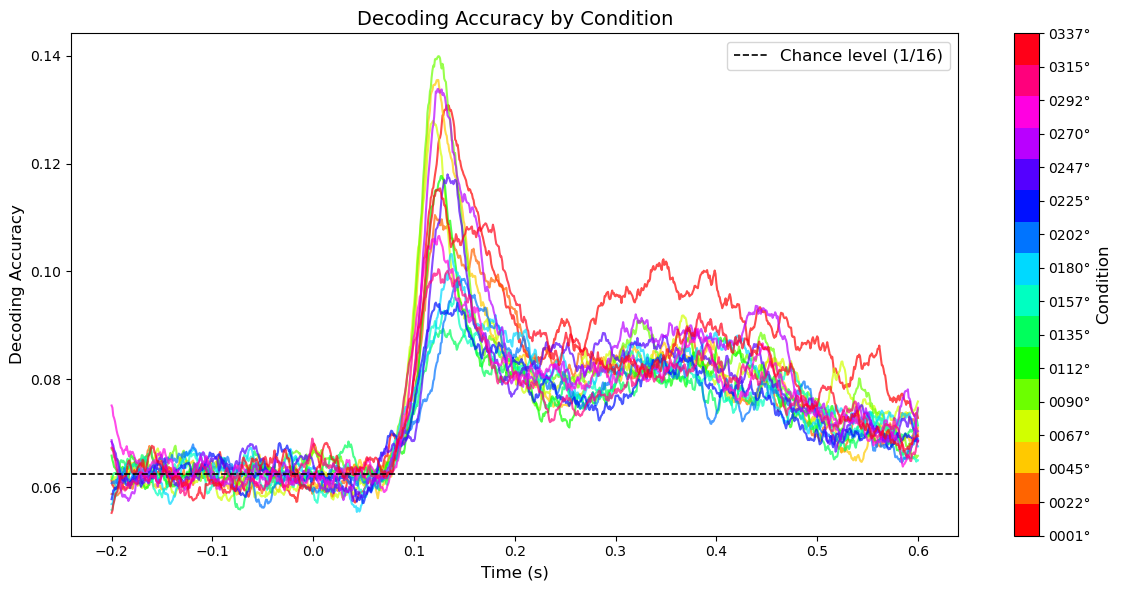

In [160]:
"Way of plotting 1 (not for paper, just to see individual conditions without rearranging the color map)"

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.ndimage import uniform_filter1d

# Load data 
file_path = '/Users/sm6511/Desktop/NIH_Experiment/!Important Data/Anisotropy/Proportions/MeanedIndividualConditionData.npy'
final_condition_accuracy = np.load(file_path, allow_pickle=True).item()
times_path = '/Users/sm6511/Desktop/NIH_Experiment/!Important Data/times/TimesForPlots.npy'
times = np.load(times_path)

# Plot setup 
fig, ax = plt.subplots(figsize=(12, 6))
colormap = cm.get_cmap('tab20', len(final_condition_accuracy))

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

n_conditions = len(final_condition_accuracy)

# Circular colormap
colormap = cm.get_cmap('hsv', n_conditions)

# Map each condition index to a color
colors = [colormap(i) for i in range(n_conditions)]

def desaturate(color, amount):
    import matplotlib.colors as mcolors
    c = np.array(mcolors.to_rgb(color))
    return tuple(c + (1 - c) * amount)


window_size = 20 # number of samples to average over

for idx, (cond, acc_curve) in enumerate(sorted(final_condition_accuracy.items(), key=lambda x: int(x[0]))):
    smoothed = uniform_filter1d(acc_curve, size=window_size, mode='nearest')  # smooth
    desat_color = desaturate(colors[idx], amount=0)
    ax.plot(times, smoothed, color=desat_color, alpha=0.7, linewidth=1.5)


# Horizontal chance line
chance_line = ax.axhline(1.0 / len(final_condition_accuracy), color='k', linestyle='--', linewidth=1.2, label='Chance level (1/16)')
ax.legend(handles=[chance_line], loc='upper right', fontsize=12)

# Labels and title
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Decoding Accuracy', fontsize=12)
ax.set_title('Decoding Accuracy by Condition', fontsize=14)

# Add colorbar legend mapped to conditions
norm = Normalize(vmin=0, vmax=len(final_condition_accuracy)-1) #Take indices of conditions and map them for the colorbar
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # for color bar
cbar = fig.colorbar(sm, ax=ax, ticks=range(len(final_condition_accuracy)))
cbar.ax.set_yticklabels([f"{k}°" for k in sorted(final_condition_accuracy.keys())])
cbar.set_label('Condition', fontsize=12)

#ax.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()




/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_84020/617711843.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{y*100:.0f}%" for y in yticks]) #show decoding %


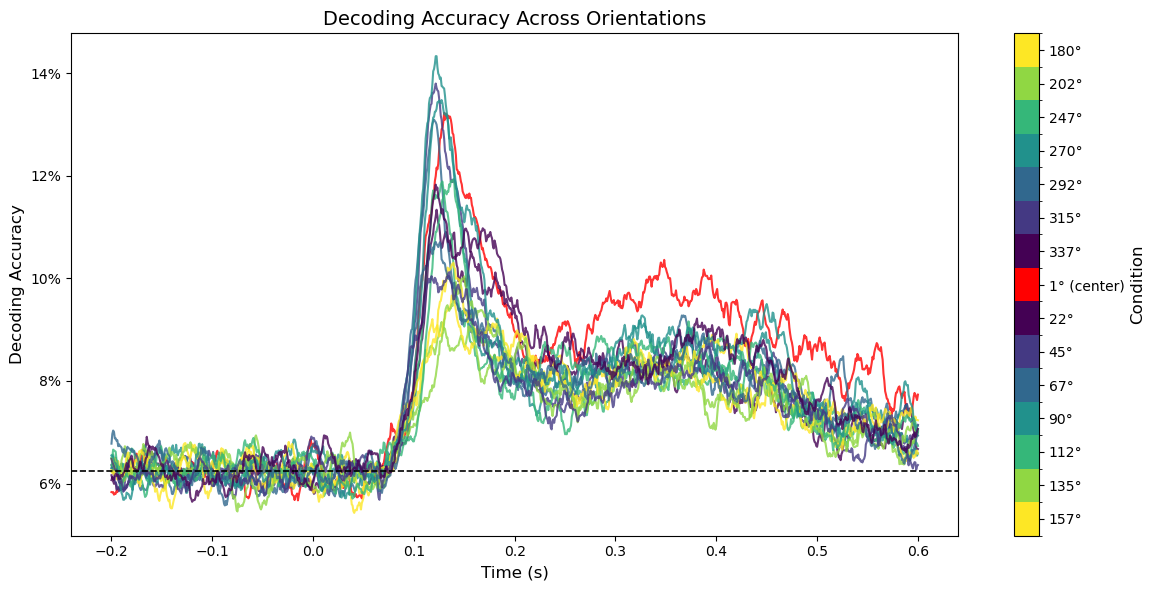

In [ ]:
"Way of plotting 1 (for paper, rearranging the color map to have reference in middle and mirrored pairs)"

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable
from scipy.ndimage import uniform_filter1d

# --- Load data ---
file_path = '/Users/sm6511/Desktop/NIH_Experiment/!Important Data/Anisotropy/Proportions/MeanedIndividualConditionData.npy'
final_condition_accuracy = np.load(file_path, allow_pickle=True).item()
times_path = '/Users/sm6511/Desktop/NIH_Experiment/!Important Data/times/TimesForPlots.npy'
times = np.load(times_path)

# --- Parameters ---
window_size = 15 #Smoothing for visibility, number of samples to average over. With 16 lines, hard to see without some smoothing
conditions = ['0001', '0022', '0045', '0067', '0090', '0112', '0135', '0157', 
              '0180', '0202', '0225', '0247', '0270', '0292', '0315', '0337']

# Mirrored pairs (this defines deviations from the center orientation)
pairs = [
    ('0022', '0337'),
    ('0045', '0315'),
    ('0067', '0292'),
    ('0090', '0270'),
    ('0112', '0247'),
    ('0135', '0202'),
    ('0157', '0202'),
]

ref = '0001'  # reference in middle

# --- Build order: start with ref in middle, add pairs outward ---
colorbar_order = [ref]
for left_cond, right_cond in pairs:
    colorbar_order = [left_cond] + colorbar_order + [right_cond]

# --- Assign colors ---
gradient = plt.get_cmap('viridis', len(pairs)) # 7 colors for pairs
condition_to_color = {ref: (1, 0, 0)}  # bright red for reference

for idx, (left_cond, right_cond) in enumerate(pairs):
    color = gradient(idx)
    condition_to_color[left_cond] = color
    condition_to_color[right_cond] = color

# Get colors in order for plotting
plot_colors = [condition_to_color[c] for c in conditions]
colorbar_colors = [condition_to_color[c] for c in colorbar_order]

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 6))

for cond in conditions:
    acc_curve = final_condition_accuracy[cond]
    smoothed = uniform_filter1d(acc_curve, size=window_size, mode='mirror')
    ax.plot(times, smoothed, color=condition_to_color[cond], alpha=0.8, linewidth=1.5)

# Horizontal chance line
ax.axhline(1/16, color='k', linestyle='--', linewidth=1.2)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Decoding Accuracy', fontsize=12)
ax.set_title('Decoding Accuracy Across Orientations', fontsize=14)

# --- Colorbar with tick labeling ---
listed_cmap = ListedColormap(colorbar_colors)
bounds = np.arange(len(colorbar_colors) + 1)  # one boundary per color
norm = BoundaryNorm(bounds, ncolors=len(colorbar_colors))
sm = ScalarMappable(cmap=listed_cmap, norm=norm)
sm.set_array([])

ticks = np.arange(len(colorbar_colors)) + 0.5  # center ticks in each bin
cbar = fig.colorbar(sm, ax=ax, ticks=ticks)
colorbar_labels = []
for k in colorbar_order:
    if k == '0001':
        colorbar_labels.append('1° (center)')       # reference in the middle
    else:
        colorbar_labels.append(f"{int(k)}°")  # remove leading zeros
cbar.ax.set_yticklabels(colorbar_labels)
cbar.set_label('Condition', fontsize=12)
yticks = ax.get_yticks()  
ax.set_yticklabels([f"{y*100:.0f}%" for y in yticks]) #show decoding %

plt.tight_layout()
plt.show()


('0022', '0337')
('0045', '0315')
('0067', '0292')
('0090', '0270')
('0112', '0247')
('0135', '0225')
('0157', '0202')


/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_84020/2941105520.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{y*100:.0f}%" for y in yticks])


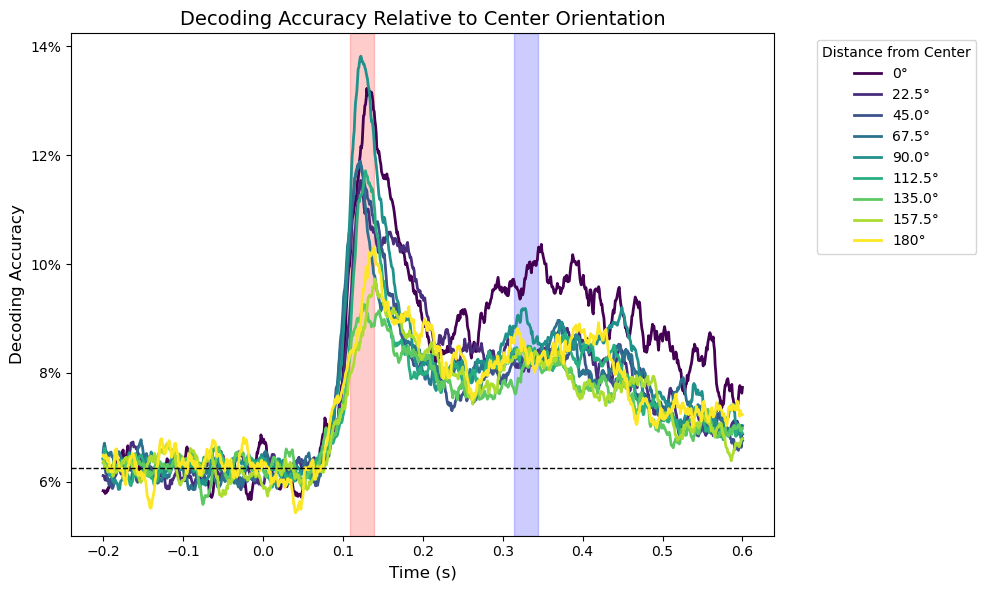

In [229]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
import pandas as pd

# --- Load data ---
file_path = '/Users/sm6511/Desktop/NIH_Experiment/!Important Data/Anisotropy/Proportions/MeanedIndividualConditionData.npy'
final_condition_accuracy = np.load(file_path, allow_pickle=True).item()
times_path = '/Users/sm6511/Desktop/NIH_Experiment/!Important Data/times/TimesForPlots.npy'
times = np.load(times_path)
df = pd.read_csv('/Users/sm6511/Desktop/NIH_Experiment/!Important Data/LDA-16way Static/Mean/Peak_Times.csv')
row_all = df.loc[df['Subject'] == 'all']
time1 = row_all['peak1_sample'].values[0]
time2 = row_all['peak2_sample'].values[0]
# --- Parameters ---
window_size = 15
ref = '0001'

# Define mirrored pairs around the center
pairs = [
    ('0022', '0337'),
    ('0045', '0315'),
    ('0067', '0292'),
    ('0090', '0270'),
    ('0112', '0247'),
    ('0135', '0225'),
    ('0157', '0202')
]

for i in pairs:
    print(i)

# Define distances from center for labeling (in degrees)
distances = [0, 22.5, 45.0, 67.5, 90.0, 112.5, 135.0, 157.5, 180]

# --- Average mirrored pairs ---
mean_curves = {}
mean_curves[0] = uniform_filter1d(final_condition_accuracy[ref], size=window_size, mode='mirror')

for d, (left, right) in zip(distances[1:-1], pairs):
    left_curve = uniform_filter1d(final_condition_accuracy[left], size=window_size, mode='mirror')
    right_curve = uniform_filter1d(final_condition_accuracy[right], size=window_size, mode='mirror')
    mean_curves[d] = (left_curve + right_curve) / 2

# Include 180° condition
mean_curves[180] = uniform_filter1d(final_condition_accuracy['0180'], size=window_size, mode='mirror')

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))

# Color map from near → far
cmap = plt.get_cmap('viridis', len(mean_curves))
for i, dist in enumerate(distances):
    ax.plot(times, mean_curves[dist], color=cmap(i), linewidth=2, label=f'{dist}°')

# Chance line
ax.axhline(1/16, color='k', linestyle='--', linewidth=1)

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Decoding Accuracy', fontsize=12)
ax.set_title('Decoding Accuracy Relative to Center Orientation', fontsize=14)

# Convert y-axis to percentage
yticks = ax.get_yticks()
ax.set_yticklabels([f"{y*100:.0f}%" for y in yticks])

# Legend
ax.legend(title='Distance from Center', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
window_radius = 18  # samples
win1 = (time1 - window_radius, time1 + window_radius)
win2 = (time2 - window_radius, time2 + window_radius)

t1_start, t1_end = times[win1[0]], times[win1[1]]
t2_start, t2_end = times[win2[0]], times[win2[1]]

# --- Highlight window regions ---
for (t_start, t_end, color, label) in [
    (t1_start, t1_end, 'red',  'Peak 1 window'),
    (t2_start, t2_end, 'blue', 'Peak 2 window')
]:
    ax.axvspan(t_start, t_end, color=color, alpha=0.2, label=label)


plt.tight_layout()
plt.show()


In [224]:
print("\n=== Peak Times per Curve ===")
peak_info = []
print('window 1 start:', t1_start, 'end:', t1_end)
for dist, curve in mean_curves.items():
    peak_idx = np.argmax(curve)
    peak_time = times[peak_idx]
    peak_value = curve[peak_idx]

    # Check if peak time falls inside either window
    in_window1 = t1_start <= peak_time <= t1_end
    in_window2 = t2_start <= peak_time <= t2_end

    peak_info.append((dist, peak_time, peak_value, in_window1, in_window2))
    print(f"{dist:>5}°  →  Peak @ {peak_time:.3f}s (accuracy={peak_value:.3f})  "
          f"{'in window1' if in_window1 else ''}"
          f"{'in window2' if in_window2 else ''}"
          f"{'' if (in_window1 or in_window2) else 'outside'}")



=== Peak Times per Curve ===
window 1 start: 0.10916666666666666 end: 0.13916666666666666
    0°  →  Peak @ 0.130s (accuracy=0.132)  in window1
 22.5°  →  Peak @ 0.122s (accuracy=0.115)  in window1
 45.0°  →  Peak @ 0.122s (accuracy=0.119)  in window1
 67.5°  →  Peak @ 0.122s (accuracy=0.119)  in window1
 90.0°  →  Peak @ 0.122s (accuracy=0.138)  in window1
112.5°  →  Peak @ 0.128s (accuracy=0.117)  in window1
135.0°  →  Peak @ 0.127s (accuracy=0.093)  in window1
157.5°  →  Peak @ 0.140s (accuracy=0.097)  outside
  180°  →  Peak @ 0.139s (accuracy=0.103)  in window1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
def circular_accuracy_plot(final_condition_accuracy, times, timepoint, output_dir, peak_label=""):
    times = times
    #time_idx = np.argmin(np.abs(times - timepoint))
    time_idx = timepoint
    #Sort conditions by their numeric value in order for circular plot
    sorted_conditions = sorted(final_condition_accuracy.items(), key=lambda x: int(x[0]))
    degrees = [int(cond) for cond, _ in sorted_conditions]
    #Convert degrees to radians for plotting
    angles = np.deg2rad(degrees)
    #Get value at specified timepoint for each condition
    window = slice(time_idx - 18, time_idx + 19)
    values = np.array([np.mean(acc_curve[window]) for _, acc_curve in sorted_conditions])

    max_val = values.max()
    scale_max = max_val * 1.1  # 10% larger than max accuracy

    # Scale values so min maps to 0, max maps slightly beyond max observed accuracy
    scaled_values = values / scale_max
    scaled_values = np.clip(scaled_values, 0, 1)

    # Close the circle
    angles = np.append(angles, angles[0])
    scaled_values = np.append(scaled_values, scaled_values[0])

    # Create polar plot
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)

    # Rotate plot so the angle corresponding to '1' is at the top (π/2 radians)
    # Find the angle of condition '1'
    ax.set_theta_direction(-1)  # makes angles go clockwise
    angle_1 = np.deg2rad(1) 
    ax.set_theta_offset(np.pi/2 - angle_1)

    # Plot line with markers only (no fill)
    ax.plot(angles, scaled_values, marker='o', linestyle='-', color='blue', linewidth=2)

    # Remove grid lines
    ax.grid(False)

    # Set angle ticks and labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([f"{d}°" for d in degrees])

    # Set radius limits and ticks, but no legend
    ax.set_ylim(0, 1)
    ax.set_yticks([])  # Hide radial ticks (accuracy scale)

    # Add radial ticks with real accuracy labels
    ax.set_ylim(0, 1)
    radial_ticks = np.linspace(0, 1, 5)
    ax.set_yticks(radial_ticks)
    ax.set_yticklabels([f"{v * scale_max:.2f}" for v in radial_ticks], fontsize=8)
    ax.set_yticklabels([])  # hide automatic radial labels
    # Place radial tick labels manually
    radial_ticks = np.linspace(0, 1, 5)
    radial_ticks = radial_ticks[:-1]
    scale_values = radial_ticks * scale_max
    angle_offset = np.pi / 6  # shift clockwise by 30 degrees
    for r, val in zip(radial_ticks, scale_values):
        ax.text(angle_offset, r, f"{val:.2f}", fontsize=8,
                horizontalalignment='left', verticalalignment='center')
    theta = np.linspace(0, 2 * np.pi, 360)  # full circle

    for r in radial_ticks:
        ax.plot(theta, np.full_like(theta, r), 
                color='gray', linestyle='--', linewidth=0.8, alpha=0.3)

    ax.set_title(f'Decoding Accuracy Across Conditions at {times[timepoint]:.3f}s', va='bottom')

    plt.tight_layout()

    fig_path = os.path.join(output_dir, f'circular_accuracy_{peak_label.replace(" ", "_")}_t{times[timepoint]:.3f}.png')
    plt.savefig(fig_path, dpi=300)
    plt.show()


961


In [243]:
import numpy as np
import matplotlib.pyplot as plt
import os

def circular_accuracy_plot(final_condition_accuracy, times, timepoint, output_dir, peak_label="", timepoint2=None):
    # Sort conditions
    sorted_conditions = sorted(final_condition_accuracy.items(), key=lambda x: int(x[0]))
    degrees = [int(cond) for cond, _ in sorted_conditions]
    angles = np.deg2rad(degrees)

    # --- Helper function to average window around a timepoint ---
    def get_windowed_values(tp):
        window = slice(tp - 18, tp + 19)  # ±18 sample window (15ms)
        return np.array([np.mean(acc_curve[window]) for _, acc_curve in sorted_conditions])

    # --- Get first (and optionally second) timepoint values ---
    values1 = get_windowed_values(timepoint)
    values_list = [values1]
    labels = [f"{times[timepoint]:.3f} ± 0.015s"]

    if timepoint2 is not None:
        values2 = get_windowed_values(timepoint2)
        values_list.append(values2)
        labels.append(f"{times[timepoint2]:.3f} ± 0.015s")

    # --- Normalize based on global max ---
    all_vals = np.concatenate(values_list)
    scale_max = all_vals.max() * 1.1

    # --- Close the circle ---
    angles = np.append(angles, angles[0])

    # --- Plot setup ---
    fig = plt.figure(figsize=(7.5,6))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi/2 - np.deg2rad(1))

    colors = ['blue', 'red']
    for i, values in enumerate(values_list):
        scaled = np.clip(values / scale_max, 0, 1)
        scaled = np.append(scaled, scaled[0])
        label = f"Peak {i+1} ({labels[i]})" 
        ax.plot(angles, scaled, marker='o', linestyle='-', color=colors[i % len(colors)],
                linewidth=2, label=label)
        
    # --- Add radial tick rings and labels (decoding accuracy) ---
    radial_ticks = np.linspace(0, 1, 5)
    theta = np.linspace(0, 2 * np.pi, 360)

    # Draw faint circular grid rings
    for r in radial_ticks[:-1]:
        ax.plot(theta, np.full_like(theta, r), color='gray', linestyle='--', linewidth=0.6, alpha=0.25, zorder=0)

    # Add numeric labels (decoding accuracy values)
    scale_values = radial_ticks[:-1] * scale_max
    for r, val in zip(radial_ticks[:-1], scale_values):
        ax.text(
            np.pi / 2, r, f"{val*100:.0f}%",
            fontsize=8, color='gray',
            ha='center', va='bottom',
            rotation=0,
            clip_on=False,
            transform=ax.transData
        )
    chance = 1/16
    chance_radius = chance / scale_max
    theta = np.linspace(0, 2 * np.pi, 360)
    ax.plot(theta, np.full_like(theta, chance_radius),
            linestyle=':', color='black', linewidth=1.5,
            label=f'Chance: 6.25%')


    # --- Formatting ---
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([f"{d}°" for d in degrees])
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    ax.grid(False)
    ax.legend(
    loc='upper right',
    bbox_to_anchor=(1.2, 1.05),
    handlelength=1.5,   # default ~2
    handletextpad=0.5,  # space between line and label
    fontsize=9         # font size
)

    ax.set_title(f'Decoding Accuracy Across Orienations')

    plt.tight_layout()
    fig_path = os.path.join(output_dir, f'circular_accuracy_{peak_label.replace(" ", "_")}.png')
    plt.savefig(fig_path, dpi=300)
    plt.show()


961


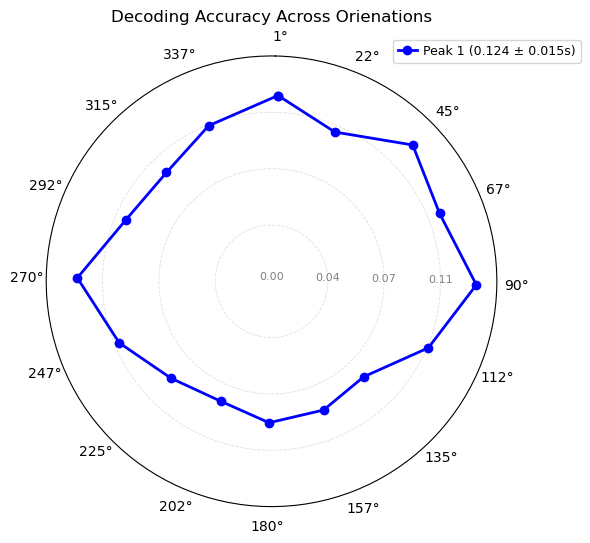

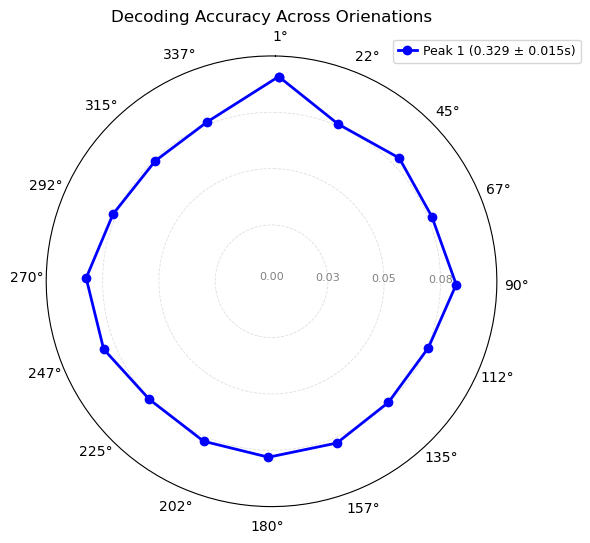

In [202]:
import pandas as pd
output_dir = '/Users/sm6511/Desktop/NIH_Experiment/Figures'
times = np.load('/Users/sm6511/Desktop/NIH_Experiment/!Important Data/times/TimesForPlots.npy')
print(len(times))
#Load in peak times for decoding
df = pd.read_csv('/Users/sm6511/Desktop/NIH_Experiment/!Important Data/LDA-16way Static/Mean/Peak_Times.csv')
row_all = df.loc[df['Subject'] == 'all']
time1 = row_all['peak1_sample'].values[0]
time2 = row_all['peak2_sample'].values[0]


circular_accuracy_plot(final_condition_accuracy, times, timepoint=time1, output_dir=output_dir, peak_label="Peak 1")
circular_accuracy_plot(final_condition_accuracy, times, timepoint=time2, output_dir=output_dir, peak_label="Peak 1")



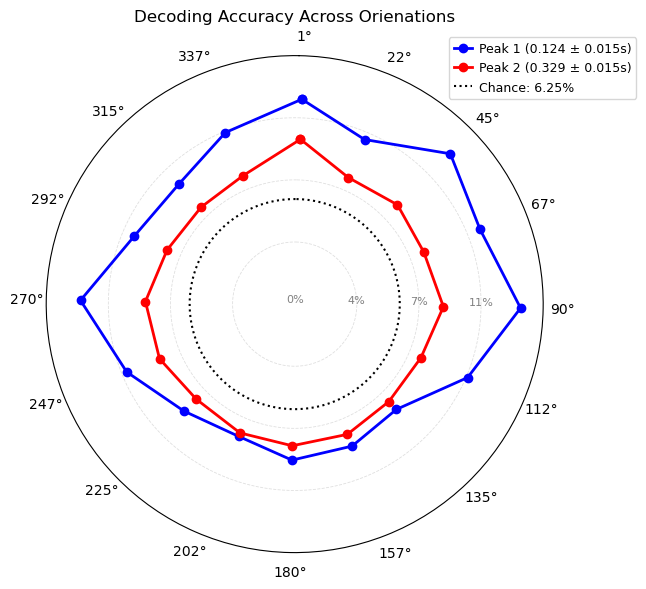

In [244]:
circular_accuracy_plot(final_condition_accuracy, times, timepoint=time1, timepoint2=time2, output_dir=output_dir, peak_label="Peak 1")

In [45]:
times = epochs_still.times
np.save(os.path.join(output_dir, 'TimesForPlots.npy'), times)

In [46]:
print(output_dir)

/System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/0Important Plots/Proportions


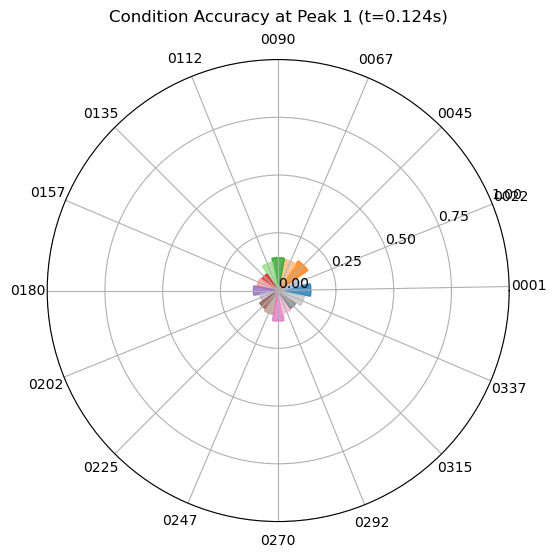

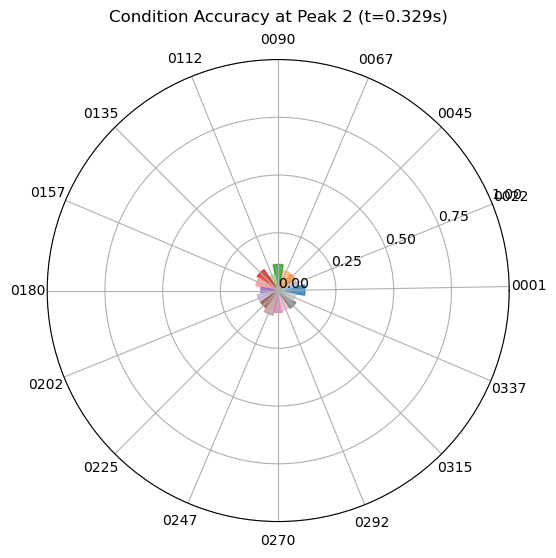

In [3]:
import pandas as pd

# ==== Load Peaks from CSV ====
peaks_csv = '/System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/0Important Plots/WithinStillSummary/Top2Peaks.csv'
peaks_df = pd.read_csv(peaks_csv)
peak_times = peaks_df['Time (s)'].values

# ==== Extract Accuracy at Each Peak Time ====
def circular_plot(accuracy_dict, timepoint, peak_label, output_dir):
    conds = sorted(accuracy_dict.keys(), key=lambda x: int(x))
    values = [accuracy_dict[c][np.argmin(np.abs(times - timepoint))] for c in conds]
    angles = np.deg2rad([int(c) for c in conds])

    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    bars = ax.bar(angles, values, width=np.deg2rad(22), bottom=0.0, alpha=0.8)

    for bar, color in zip(bars, cm.tab20.colors):
        bar.set_color(color)

    ax.set_xticks(angles)
    ax.set_xticklabels(conds)
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.set_title(f'Condition Accuracy at {peak_label} (t={timepoint:.3f}s)', va='bottom')

    fig_path = os.path.join(output_dir, f'circular_plot_{peak_label.replace(" ", "_")}.png')
    plt.savefig(fig_path, dpi=300)
    plt.show()

# Plot for both peaks
circular_plot(final_condition_accuracy, peak_times[0], "Peak 1", output_dir)
circular_plot(final_condition_accuracy, peak_times[1], "Peak 2", output_dir)
